In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from math import floor, ceil

np.random.seed(3)

def boximage(box_width, box_height, width = 128, height = 128, center = None):
    if center is None:
        center = ((height-1)/2, (width-1)/2)


    im = np.zeros((height, width), dtype=np.uint8)

    y_start = max(center[0]-box_height/2, 0)
    y_end = min(center[0]+box_height/2, height-1)

    x_start = max(center[1]-box_width/2, 0)
    x_end = min(center[1]+box_width/2, width-1)

    # Draw the edges
    im[floor(y_start), ceil(x_start):floor(x_end+1)] = 255*(ceil(y_start)-y_start)
    im[ceil(y_end), ceil(x_start):floor(x_end+1)] = 255*(y_end - floor(y_end))
    im[ceil(y_start):floor(y_end+1), floor(x_start)] = 255*(ceil(x_start) - x_start)
    im[ceil(y_start):floor(y_end+1), ceil(x_end)] = 255*(x_end - floor(x_end))

    # Draw the four corners
    im[floor(y_start), floor(x_start)] = 255*(ceil(y_start) - y_start)*(ceil(x_start) - x_start)
    im[floor(y_start), ceil(x_end)] = 255*(ceil(y_start) - y_start)*(x_end - floor(x_end))
    im[ceil(y_end), floor(x_start)] = 255*(y_end - floor(y_end))*(ceil(x_start) - x_start)
    im[ceil(y_end), ceil(x_end)] = 255*(y_end - floor(y_end))*(x_end - floor(x_end))

    # Fill the box
    im[ceil(y_start):floor(y_end+1), ceil(x_start):floor(x_end+1)] = 255


    return im

n_frames = 10
box_widths = np.hstack([np.linspace(0, 100, n_frames), np.linspace(100, 10, n_frames)])
box_heights = np.hstack([np.linspace(0, 90, n_frames), np.linspace(100, 0, n_frames)])
center_x = np.linspace(0, 200, n_frames*2)
center_y = np.linspace(0, 200, n_frames*2)
video = np.array([boximage(box_width, box_height) for box_width, box_height, cx, cy in zip(box_widths, box_heights, center_x, center_y)])



np.save('boxvideo.npy', video)

#animate video with matplotlib.funcanimation
def animate_video(video):
    %matplotlib tk

    fig, ax = plt.subplots(1, 1, figsize=(5, 10))

    def animate(frame):
        ax.clear()
        ax.imshow(video[frame], cmap='gray')
        ax.set_title(f'Frame {frame}')

    ani = animation.FuncAnimation(fig, animate, frames=range(len(video)), interval=5, repeat=False)

    return ani

#ani = animate_video(video)


In [2]:
from src.utils.misc import load_config, animate_video
import torch
from src.utils.build_model import build_model, build_model_interp



CFG = load_config('configs/config.yaml')
device = ('cuda' if torch.cuda.is_available() else 'cpu')
#model = build_model('AutoEncoder', CFG, device)
#model.load_state_dict(torch.load('data/model_weights/AutoEncoder_weights.pt', map_location=device))



# Perform frame interpolation


In [3]:
def interpolate_linear(observed_times, new_times, states):
    new_states = np.zeros((len(new_times), *states.shape[1:]))

    for j, time in enumerate(new_times):
        # find the two closest observed times
        idx = np.searchsorted(observed_times, time)
        if idx == 0:
            new_states[j] = states[0]
        elif idx == len(observed_times):
            new_states[j] = states[-1]
        else:
            # linearly interpolate between the two closest observed times
            alpha = (time - observed_times[idx-1]) / (observed_times[idx] - observed_times[idx-1])
            new_states[j] = alpha * states[idx] + (1 - alpha) * states[idx-1]

    return new_states


interpolated_video = interpolate_linear(np.arange(len(video)), np.arange(0, len(video), 0.1), video)

#ani = animate_video(interpolated_video)


# Train Autoencoder

In [4]:
from torch.utils.data import DataLoader
from src.training.trainer import Trainer

training_data = list(video.astype(np.float32))
train_loader = DataLoader(dataset=training_data, batch_size=CFG['training']['batch_size'], shuffle=True)

model = build_model_interp('AutoEncoder', CFG, device)

trainer = Trainer(model, train_loader, config_path = 'configs/config.yaml', device = device)

In [5]:
losses = trainer.train()

Training:   0%|          | 0/1200 [00:00<?, ?iter/s]

Training: 100%|██████████| 1200/1200 [01:24<00:00, 14.18iter/s, Current loss=17.4] 


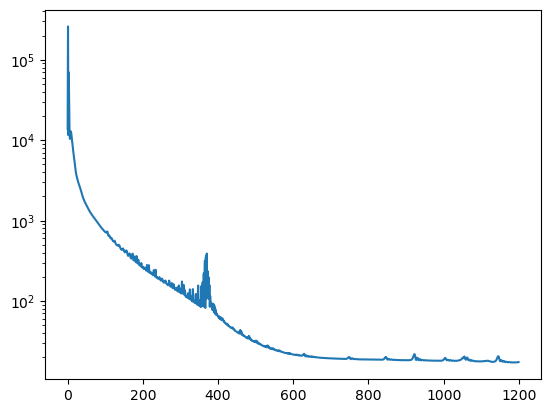

17.192506790161133


In [6]:
%matplotlib inline
plt.semilogy(losses)
plt.show()
print(np.min(losses))

In [7]:
data = video.astype(np.float32)
data = list(DataLoader(dataset=data, batch_size=len(data), shuffle=False))[0]
output = model(data.to(device)).detach().cpu().numpy()

print(np.mean(np.square(output - data.numpy())))

%matplotlib tk
animate_video(output)

17.486673


# Perform frame interpolation in encoded space

In [8]:
encoded = model.encoder(data.to(device)).detach().cpu().numpy()
encoded_interpolated = interpolate_linear(np.arange(len(encoded)), np.arange(0, len(encoded), 0.1), encoded).astype(np.float32)
output_interpolated = model.decoder(torch.tensor(encoded_interpolated).to(device)).detach().cpu().numpy()

animate_video(output_interpolated)

In [9]:
animate_video(interpolated_video)